# Model Interpretability: LIME

In [1]:
# Obviously
import pandas as pd

# Some sklearn tools for preprocessing. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

### The Dataset

In [2]:
# Load data and create lists of numerical and categorical features

df = pd.read_csv("data/bank.csv")

# Get X, y
y = df["y"].map({"no": 0, "yes": 1})
X = df.drop("y", axis=1)

num_features = ["age", "campaign", "pdays", "previous"]

cat_features = ["job", "marital", "education","default", "housing", "loan", "contact", 
                "month", "day_of_week", "poutcome"]

Description of features:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
13. previous: number of contacts performed before this campaign and for this client (numeric)
14. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [3]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

Let's create a preprocessor as before, and use the same gymnastics to get nice name for our new dummy features. 
Here we'll keep both the raw data `X_train` and processed one `X_train_processed` as we will need both of them for LIME.

In [4]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [5]:
# Train preprocessor
preprocessor.fit(X_train)

# Get the list of categories generated by the process
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

# Create nice names for our one hot encoded features
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

# Create a new list with all names of features
all_features = num_features + new_ohe_features

# Save processed data
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), columns=all_features)
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), columns=all_features)

### The models

Since we've tuned and trained the models in the previous notebook, here we'll just do everything at once so we can focus on interpreting them.

In [6]:
# Logistic Regression
lr_model = LogisticRegression(C=1.3, class_weight="balanced", solver="liblinear", random_state=42)

lr_model.fit(X_train_processed, y_train)

LogisticRegression(C=1.3, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [7]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=10, min_samples_split=.01)

dt_model.fit(X_train_processed, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=0.01)

In [8]:
# Random Forest
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, n_jobs=-1, 
                                                      min_samples_split=.01, max_depth=15)

rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=0.01, n_estimators=150, n_jobs=-1)

In [9]:
# LightGBM
lgb_model = LGBMClassifier(class_weight="balanced", n_jobs=-1, 
                                              max_depth=10, min_child_samples=40, n_estimators=50)

lgb_model.fit(X_train_processed, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=10, min_child_samples=40,
               n_estimators=50)

## LIME to generate local intepretations of black box models

LIME stands for `Local Interpretable Model-Agnostic Explanations`. We can use it with any model we've built in order to explain why it took a specific decision for a given observation. To do so, LIME creates a dataset in the locality of our observation by perturbating the different features. Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

### Create an explainer

In order to explain why the model classifies invidividual observations as class 0 or 1, we are going to use the `LimeTabularExplainer` from the library `lime`, this is the main explainer to use for tabular data. Lime also provides an explainer for text data, for images and for time-series.

When using the tabular explainer, we need to provide our training set as parameter so that `lime` can compute statistics on each feature, either `mean` and `std` for numerical features, or frequency of values for categorical features. Those statistics are used to scale the data and generate new perturbated data to train our local linear models on.

In [10]:
! pip install lime

In [11]:
from lime.lime_tabular import LimeTabularExplainer

The parameters passed to the explainer are:
- our training set, we need to make sure we use the training set *without* one hot encoding - `X_train`
- `mode`: the explainer can be used for classification or regression
- `feature_names`: list of labels for our features
- `categorical_features`: list of indexes of categorical features
- `categorical_names`: dict mapping each index of categorical feature to a list of corresponding labels
- `dicretize_continuous`: will discretize numerical values into buckets that can be used for explanation. For instance it can tell us that the decision was made because distance is in bucket [5km, 10km] instead of telling us distance is an importante feature.

First, in order to get the `categorical_names` parameter in the right format, we need to build a dictionary with indexes of categorical values in original dataset as keys and lists of possible categories as values. The code below does just that: going through all categorical features, getting their index to use as a key and then listing all possible values for that feature. We get the possible values from the attribute `categories` of our one hot encoder.

In [12]:
categorical_names = {}

# List of all possible values per feature
cat_values = preprocessor.named_transformers_["categorical"].categories_

for col, val in zip(cat_features, cat_values):
    
    categorical_names[df.columns.get_loc(col)] = list(val)

In [13]:
categorical_names

{1: ['admin.',
  'blue-collar',
  'entrepreneur',
  'housemaid',
  'management',
  'retired',
  'self-employed',
  'services',
  'student',
  'technician',
  'unemployed',
  'unknown'],
 2: ['divorced', 'married', 'single', 'unknown'],
 3: ['basic.4y',
  'basic.6y',
  'basic.9y',
  'high.school',
  'illiterate',
  'professional.course',
  'university.degree',
  'unknown'],
 4: ['no', 'unknown', 'yes'],
 5: ['no', 'unknown', 'yes'],
 6: ['no', 'unknown', 'yes'],
 7: ['cellular', 'telephone'],
 8: ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'],
 9: ['fri', 'mon', 'thu', 'tue', 'wed'],
 13: ['failure', 'nonexistent', 'success']}

`Lime` needs the dataset that is passed to have categorical values converted to integer labels that maps to the values in `categorical_names`. For instance, label `0` for the column `2` will map to `divorced`. We will use a custom helper function to do so, that converts data from original to LIME and from LIME to original format.

That function is going over all categorical features and replacing strings by the correct integer labels, feel free to check `helpers.py`.

In [14]:
from helpers import convert_to_lime_format

Let's check that it worked:

In [15]:
convert_to_lime_format(X_train, categorical_names).head()

age  job  marital  education  default  housing  loan  contact  month  \
7309    50    1        2          0        0        0     0        1      6   
4169    51    7        1          5        1        0     0        1      6   
35810   46    9        0          5        0        2     0        0      6   
9668    46    0        2          6        0        2     0        1      4   
34389   25    7        2          3        0        0     0        0      6   

       day_of_week  campaign  pdays  previous  poutcome  
7309             2         2    999         0         1  
4169             1         5    999         0         1  
35810            1         2    999         0         1  
9668             1         1    999         0         1  
34389            2         5    999         0         1

Great, now we have all we need to create an explainer.

Create a new `explainer` using the `LimeTabularExplainer`. You need to pass:
- your training data with categorical values converted to LIME format (what we did above). It also needs to be a numpy array (not a DataFrame)
- specify a `mode`
- `feature_names`: a list of names for your columns
- `categorical_names`: our dictionary that maps categorical features to their possible values
- `categorical_features`: list of index of categorical features (can use the keys of our dictionary above)
- `random_state`: pick one!

In [16]:
explainer = LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns,
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 random_state=42)


Great, our explainer is ready. Now let's pick an observation we want to explain.

#### Explain new observations

We'll create a variable called `observation` that contains our ith observation in the test dataset.

In [17]:
i = 4

# First we can check the row in the non-processed dataset
print(X_test.iloc[i])

# Then we extract the observation from the processed dataset
X_observation = X_test_processed.iloc[[i], :]
X_observation

age                           27
job                      unknown
marital                   single
education      university.degree
default                       no
housing                      yes
loan                          no
contact                 cellular
month                        jun
day_of_week                  wed
campaign                       4
pdays                          3
previous                       2
poutcome                 success
Name: 39993, dtype: object


age  campaign  pdays  previous  job__admin.  job__blue-collar  \
4  27.0       4.0    3.0       2.0          0.0               0.0   

   job__entrepreneur  job__housemaid  job__management  job__retired  ...  \
4                0.0             0.0              0.0           0.0  ...   

   month__oct  month__sep  day_of_week__fri  day_of_week__mon  \
4         0.0         0.0               0.0               0.0   

   day_of_week__thu  day_of_week__tue  day_of_week__wed  poutcome__failure  \
4               0.0               0.0               1.0                0.0   

   poutcome__nonexistent  poutcome__success  
4                    0.0                1.0  

[1 rows x 57 columns]

Check the predicted proba with each of your models, on this specific observation:

In [18]:
print(f"""\
* True label: {y_test.iloc[i]}
* LR: {lr_model.predict_proba(X_observation)[0]}
* DT: {dt_model.predict_proba(X_observation)[0]}
* RF: {rf_model.predict_proba(X_observation)[0]}
* LGB: {lgb_model.predict_proba(X_observation)[0]}""")


* True label: 1
* LR: [0.03909843 0.96090157]
* DT: [0.05048887 0.94951113]
* RF: [0.14313975 0.85686025]
* LGB: [0.10629251 0.89370749]


Let's convert our observation to lime format and convert it to a numpy array.

In [19]:
observation = convert_to_lime_format(X_test.iloc[[i], :],categorical_names).values[0]
observation

array([27, 11,  2,  6,  0,  2,  0,  0,  4,  4,  4,  3,  2,  2],
      dtype=int64)

In order to explain a prediction, we use the `explain_instance` method on our explainer. This will generate new data with perturbated features around the observation and learn a local linear model. It needs to take:
- our observation as a numpy array
- a function that uses our model to predict probabilities given the data (in same format we've passed in our explainer). That means we cannot pass directly our `rf_model.predict_proba` because our pipeline expects string labels for categorical values. We will need to create a custom function `rf_predict_proba` that first converts back integer labels to strings and then calls `rf_model.predict_proba`.
- `num_features`: number of features to consider in explanation

In [20]:
# Let write a custom predict_proba functions for our models:
from functools import partial

def custom_predict_proba(X, model):
    """Takes X in LIME format, converts back to raw,
    then processes it and calls predict proba"""

    X_original = convert_to_lime_format(X, categorical_names, col_names=X_train.columns, invert=True)
    X_processed = preprocessor.transform(X_original)
    return model.predict_proba(X_processed)

lr_predict_proba = partial(custom_predict_proba, model=lr_model)
dt_predict_proba = partial(custom_predict_proba, model=dt_model)
rf_predict_proba = partial(custom_predict_proba, model=rf_model)
lgb_predict_proba = partial(custom_predict_proba, model=lgb_model)

Let's test our custom function to make sure it generates propabilities properly.

user the method `explain_instance` on our explainer with our observation (converted to LIME format), our predict_proba function for Logistic regression. You can choose how many features you want to include in your explanation, let's start with `num_features=5`

In [21]:
explanation = explainer.explain_instance(observation, lr_predict_proba, num_features=5)


Now that we have generated our explanation, we have access to several representations. The most useful one when working in a notebook is `show_in_notebook`.


On the left it shows the list of probabilities for each class, here the model classified our observation as 0 (non subsribed) with a high probability.
* If you set `show_table=True`, you will see the table with the most important features for this observation on the right.

call `show_in_notebook` on your explanation to see the visual explanation:

In [22]:
explanation.show_in_notebook(show_table=True, show_all=False)

The most important here is the central plot, it shows the contributions of the top features to the prediction (and corresponds to the weights of your linear model). The weight represents the change in the outcome when the value becomes true.

Notice that numerical values here have been discretised (that's the default in LimeTabularExplainer, look at the `discretize_continuous` parameter) -- each is now split in 4 categorical values corresponding to whether a value lies in one of the 4 quartiles. It is easier to interpret the weights of the linear model with only binary features. Indeed, the contribution of a feature in a linear model is `value * weight`,  so to interpret the weight for a continuoues feature, we need to be aware of the sign and amplitude. With categorical features we do not have this issue as value is either 0 or 1, and weights can directly be compared.

LIME is fitting a linear model on a local perturbated dataset. You can access the coefficients, the intercept and the R squared of the linear model by calling respectively `.local_exp`, `.intercept` and `.score` on your explanation. Check that the weights of the linear model correspond to the values displayed above.

In [23]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(7, 0.2049876687757643), (8, 0.11376292223846343), (4, 0.1039557424478739), (10, -0.10058567559164157), (12, 0.05163289957147146)]}
{1: 0.2601676850661608}
0.5303022961992039


If your R-squared is low, the linear model that LIME fitted isn't a great approximation to your model, which means you should not rely too much on the explanation it provides.

You can also save the explanation to an html file with `save_to_file` to share it:

In [24]:
explanation.save_to_file("explanation.html")


Use your explainer to explain the decision tree model on the same observation (don't forget to check the score of the explanation):

In [25]:
explanation = explainer.explain_instance(observation, dt_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)


0.22220385036735624


Use your explainer to explain the random forest model on the same observation (don't forget to check the score of the explanation):

In [26]:
explanation = explainer.explain_instance(observation, rf_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)


0.4879316093373941


Use your explainer to explain the lgb model on the same observation (don't forget to check the score of the explanation):

In [27]:
explanation = explainer.explain_instance(observation, lgb_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)


0.30546399322985385


# Intepreting models with non tabular data

The tools we have seen above also work with text data and images. There are plenty of examples available online for text-data. Here we will just demonstrate how to use `Lime` to explain an image classifier.

## Interpreting image classifiers

Lime can also be used to explain decisions made for image classification. 

In this example we will use the pretrained `InceptionV3` model available with Keras. Lime is quite slow with images, so it's wiser to stick to a "shallow" deep learning model.

In [28]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

Let's create a new instance of InceptionV3

In [29]:
model = InceptionV3()

Now we'll load a picture of a toucan, we need to make sure we load it at the good size for inception, here 229*229

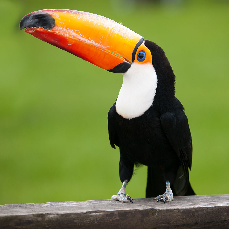

In [30]:
image_raw = load_img("data/toucan.jpg", target_size=(229, 229))
image_raw

We need to process the image to get a numpy array compatible with our model. Here we simply loads it to an array, reshape it and use the preprocess_input method provided by Keras that ensures all the preprocessing steps are made for us.

In [55]:
# Convert to numpy array, reshape and preprocess
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

Now that our image is ready, generate predictions by using `.predict` as usual.

In [56]:
predictions = model.predict(image)

You can check what labels your predictions correspond to by calling the function `decode_predictions` on your predictions. By default it returns the 5 more likely predictions

In [57]:
decode_predictions(predictions)

[[('n01843383', 'toucan', 0.9999995),
  ('n04146614', 'school_bus', 2.1847525e-07),
  ('n02607072', 'anemone_fish', 8.597696e-08),
  ('n01829413', 'hornbill', 4.3906283e-08),
  ('n04154565', 'screwdriver', 1.18218155e-08)]]

Great, we predicted a toucan with a probability of 99%, that's promising!

Remember that LIME needs the indices of the class we are interested in. Execute the cell bellow to get the indices corresponding to the 5 most probably classes we predicted above. Those indices correspond to the classes used in the ImageNet dataset that was used to train our model.

In [58]:
model.predict(image).argsort()[0, -5:][::-1]

array([ 96, 779, 393,  93, 784], dtype=int64)

Here the toucan corresponds to index 96, the school bus to index 779, etc..

Let's get started. First import the `LimeImageExplainer` and instantiate a new explainer

In [59]:
from lime.lime_image import LimeImageExplainer

In [60]:
explainer = LimeImageExplainer()

The explainer is the same as before, we call `explain_instance` to generate a new explanation. We need to provide:
- our observation: here the first row of our numpy matrix (that has only one row since we only have one image)
- our predict function, we can simply use the one from our model here
- `top_labels` the number of classes to explain. Here our model generate probabilities for more than a 1000 classes (and we looked at the five first). We do not want LIME to generate local models to explain each of those classes. As lime is pretty slow with images, let's only ask for the explanation to our two main classes, toucan and school bus
- `num_samples`: the number of new datapoints to create to fit a linear model, let's set it to 1000

*WARNING*: that will be slow. 

In [61]:
img = image[0].astype('double')

In [62]:
explanation = explainer.explain_instance(img, model.predict,top_labels=2, num_samples=1000,random_seed=42)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

First let's check the explanation for the predicted class `toucan`. That corresponds to label 96 in the ImageNet classes. We need to use the method `get_image_and_mask` on our explanation object with the following parameters:
- index of the class to explain. We'll start with the index of the main class predicted, that was 96
- positive_only: in order to show the part of the image that contribute positively to this class being selected
- num_features: number of superpixels to use. LIME breaks down our image into a set of superpixels, each containing several pixels. Those superpixels are equivalent to `features` in tabular data.
- hide_rest: to hide the rest of the image

That returns a new image and a mask as numpy arrays. You can then use `mark_boundaries` to show the image together with the mask.

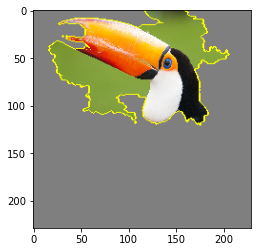

In [64]:
temp, mask = explanation.get_image_and_mask(96, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

What feature do you expect to be the most important in that decision? Plot the image with only the main feature (`num_features=1`)

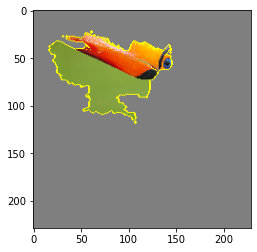

In [65]:
temp, mask = explanation.get_image_and_mask(96, positive_only=True, num_features=1, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

The second class predicted by our model was a bus (label 779), set `positive_only=False` in order to see what features contributed positively and negatively to that decision. What do you see?

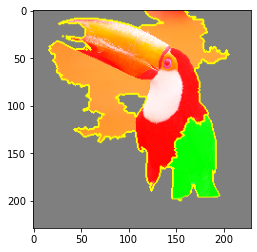

In [68]:
temp, mask = explanation.get_image_and_mask(779, positive_only=False, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Great, now you can try to change the number of features you're looking at and deactivate `positive_only` in order to see features that contribute negatively to the class. You can also look at other classes or try other pictures.